In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [6]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

## Example image

In [7]:
from PIL import Image

image = Image.open('images/cars.jpg')
image = np.array(image.convert("RGB"))

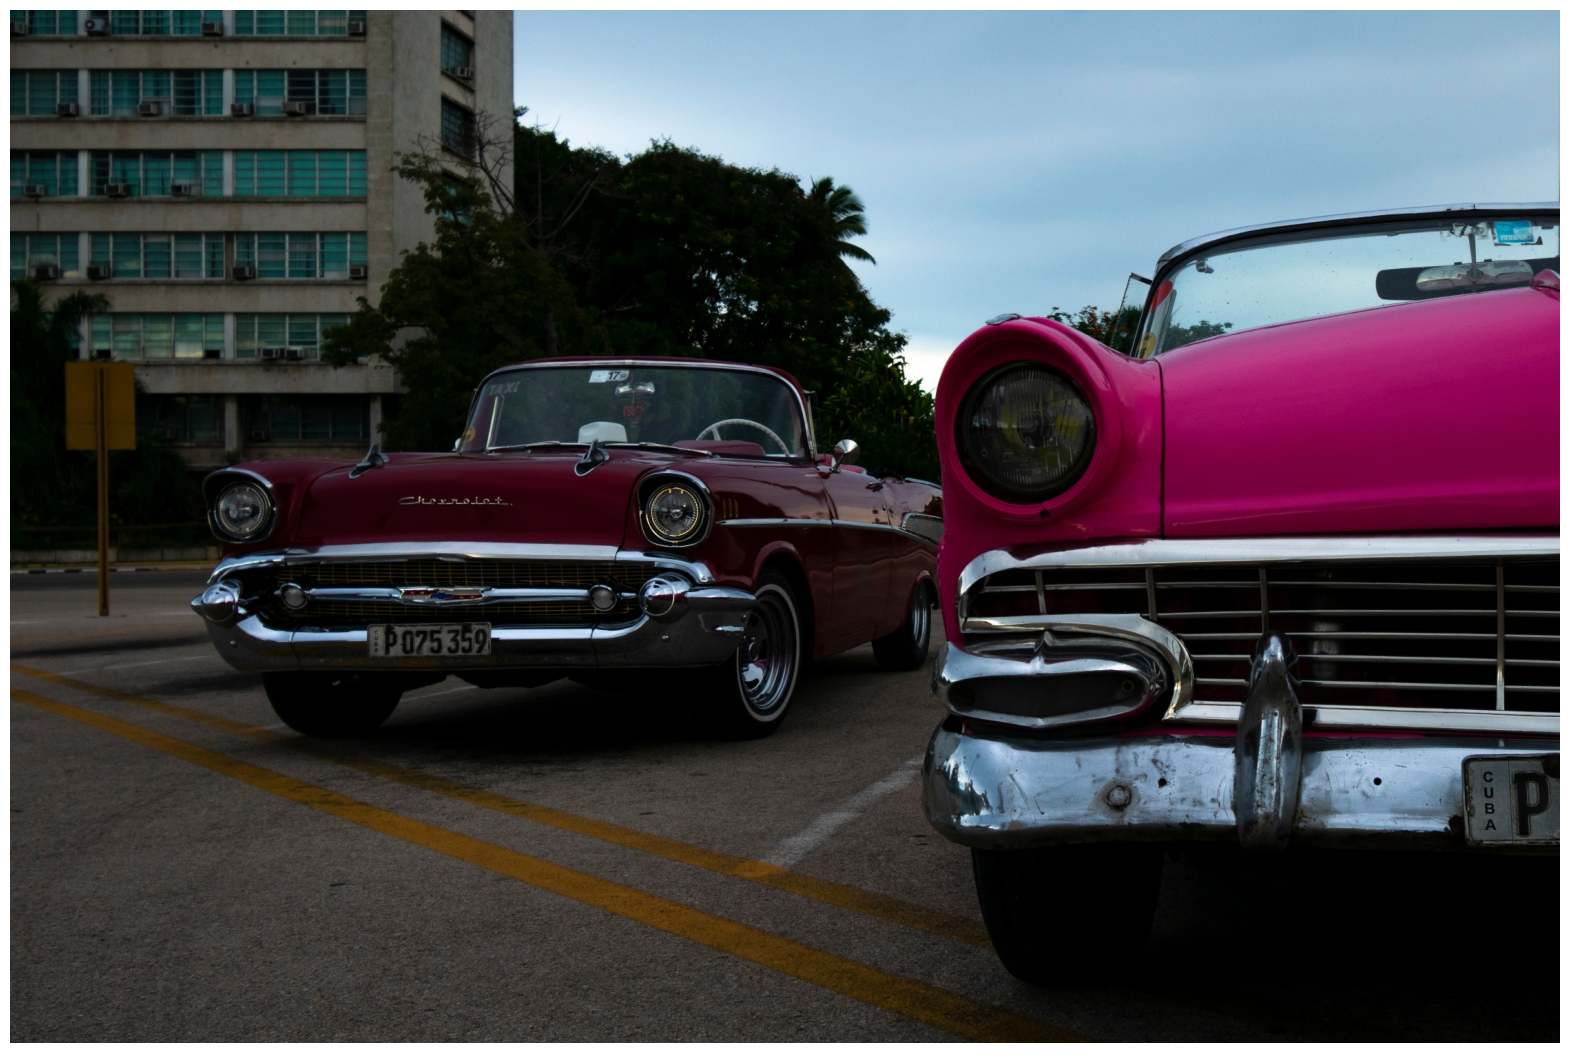

In [8]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Mask Generation on LLaVA pretrianing set

In [9]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    model = sam2,
    points_per_batch=6,
    pred_iou_thresh=0.9,
    # stability_score_thresh=0.97,
)

In [8]:
import json

data = json.load(open('/mnt/nushare2/data/mnulli/pretrainingdata/blip_laion_cc_sbu_558k.json'))
data[0]

{'id': '004539375',
 'image': '/mnt/nushare2/data/baliao/multimodal/data/LLaVA-Pretrain/images/00453/004539375.jpg',
 'conversations': [{'from': 'human',
   'value': 'Render a clear and concise summary of the photo.\n<image>'},
  {'from': 'gpt',
   'value': 'select luxury furniture 3 - inch gel memory foam mattress topper'}]}

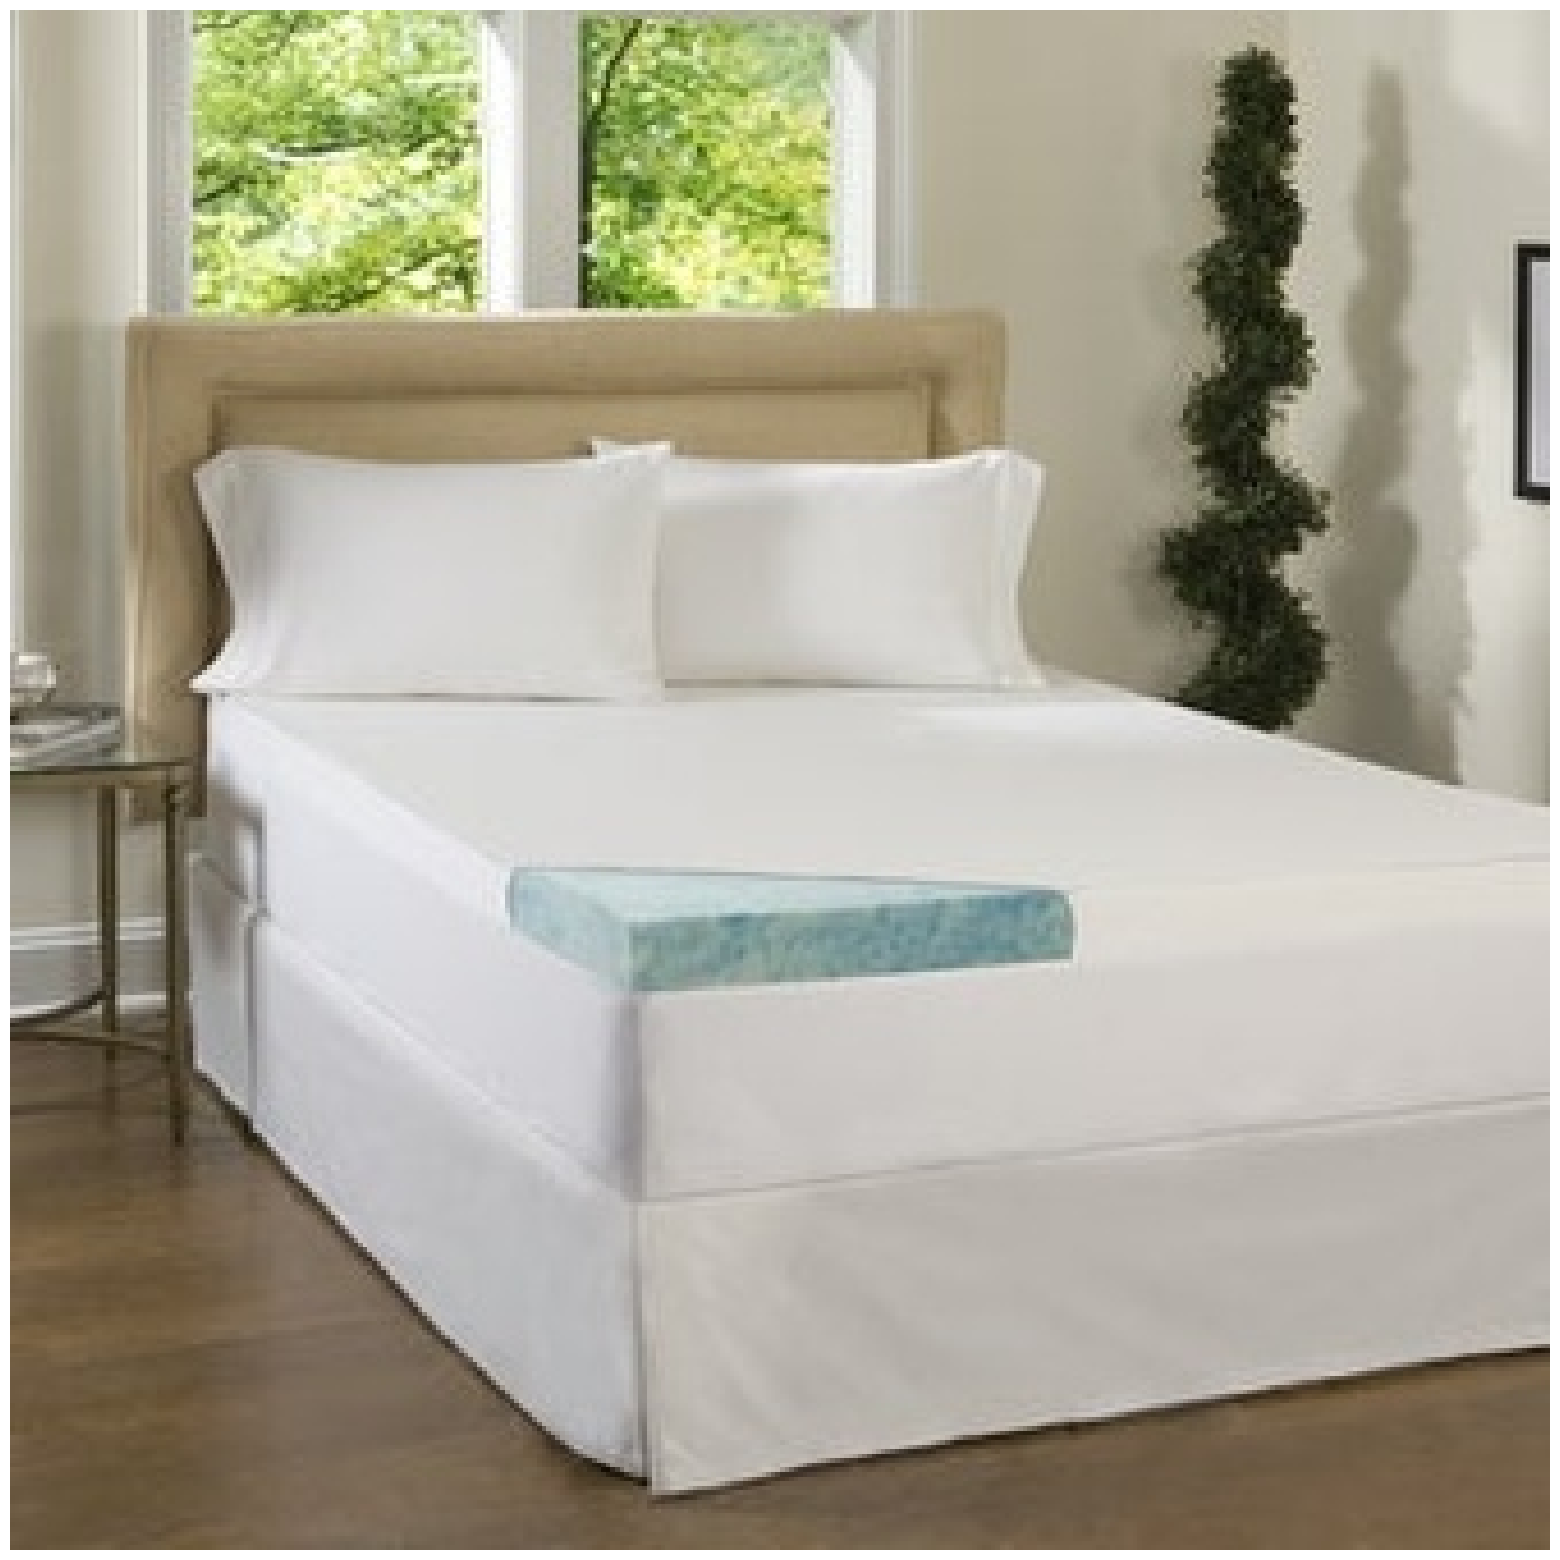

In [11]:
from PIL import Image

image = Image.open(data[0]['image'])
image = np.array(image.convert("RGB"))

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
masks = mask_generator.generate(image)

In [13]:
# print(masks)
print(len(masks))
print(masks[0].keys())

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [14]:
print(masks)

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(336, 336)), 'area': 14838, 'bbox': [0.0, 204.0, 335.0, 131.0], 'predicted_iou': 0.9921875, 'point_coords': [[5.25, 246.75]], 'stability_score': 0.97630774974823, 'crop_box': [0.0, 0.0, 336.0, 336.0]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(336, 336)), 'area': 5054, 'bbox': [41.0, 95.0, 101.0

Show all the masks overlayed on the image.

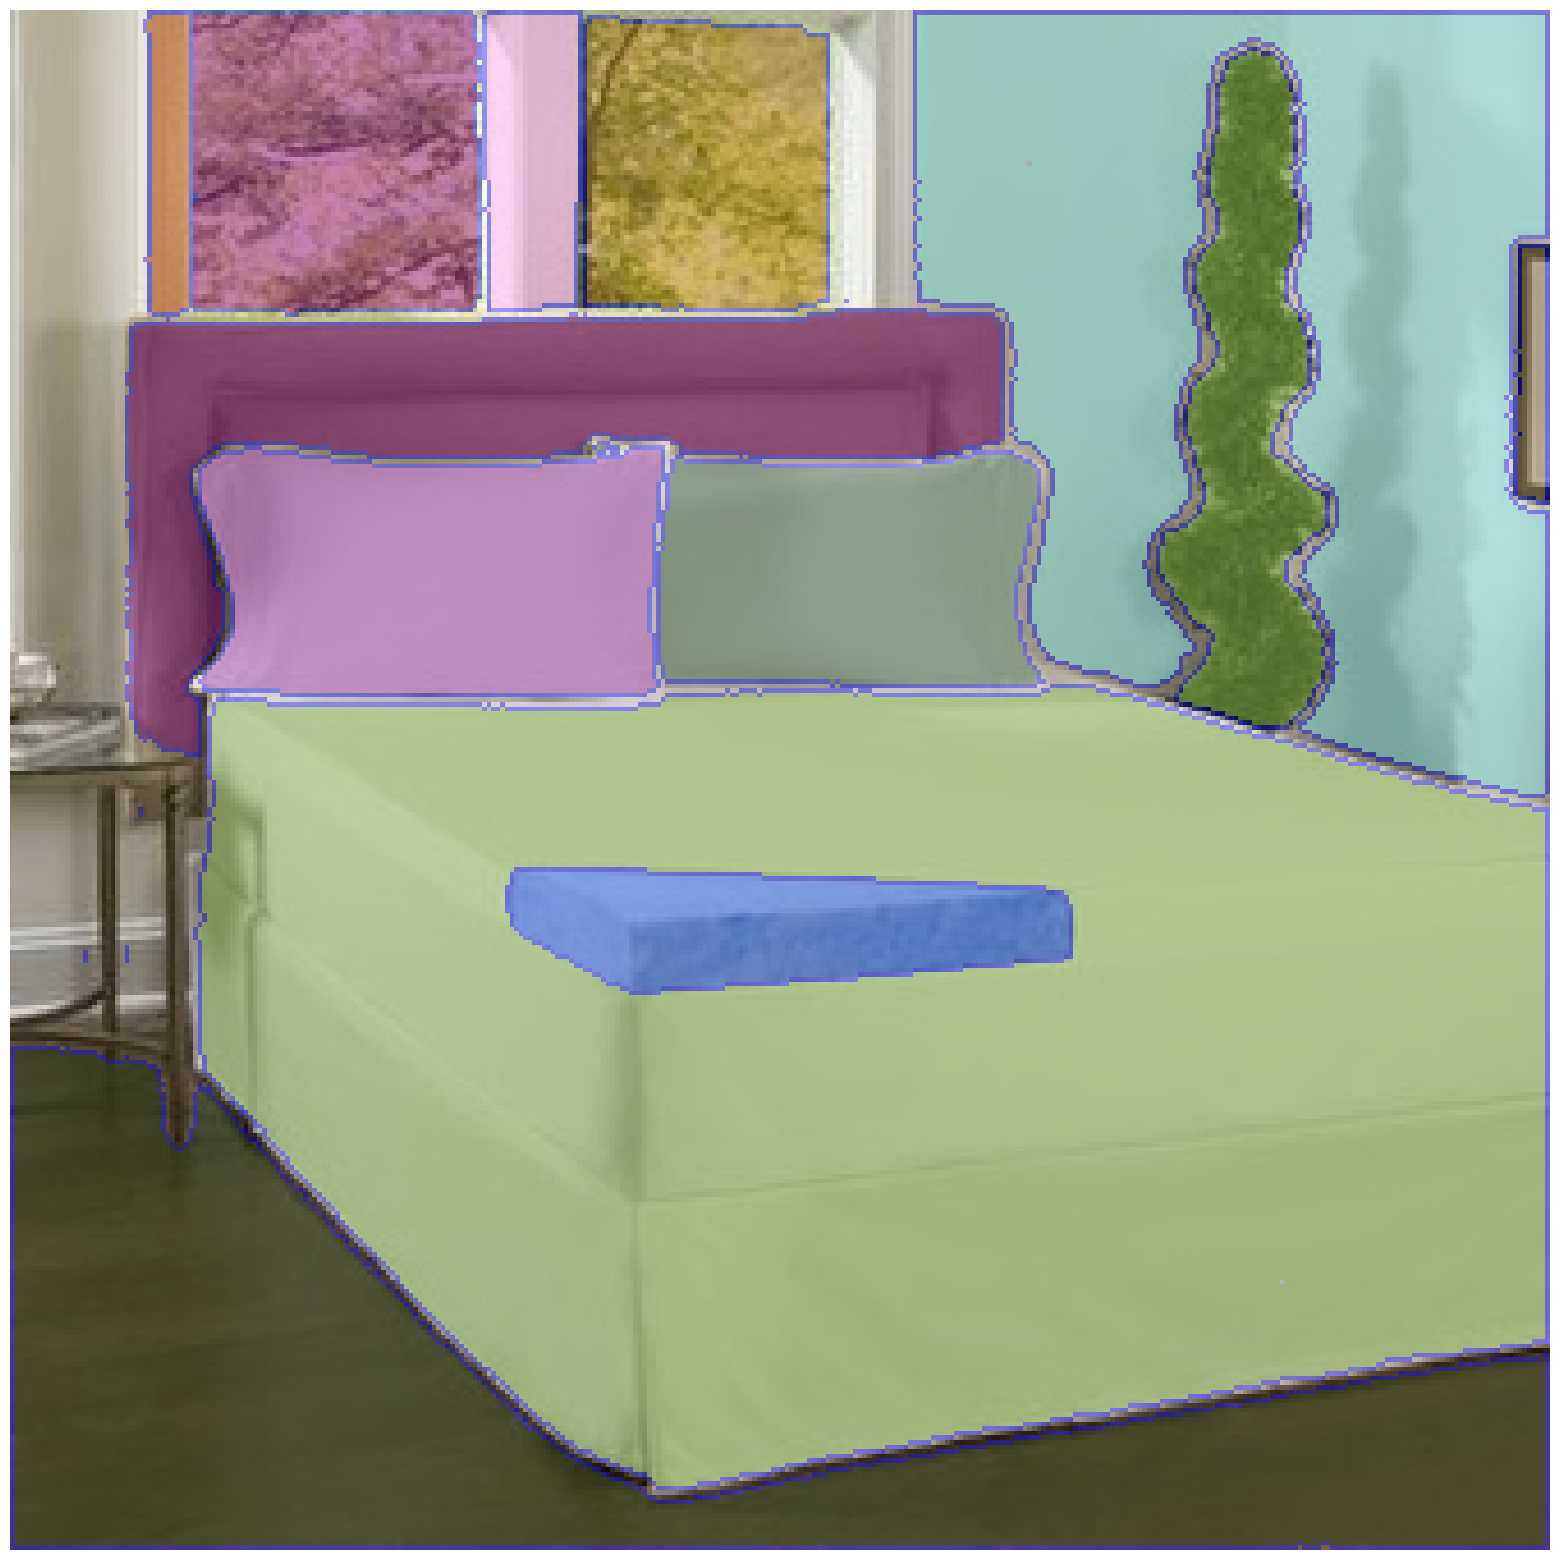

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

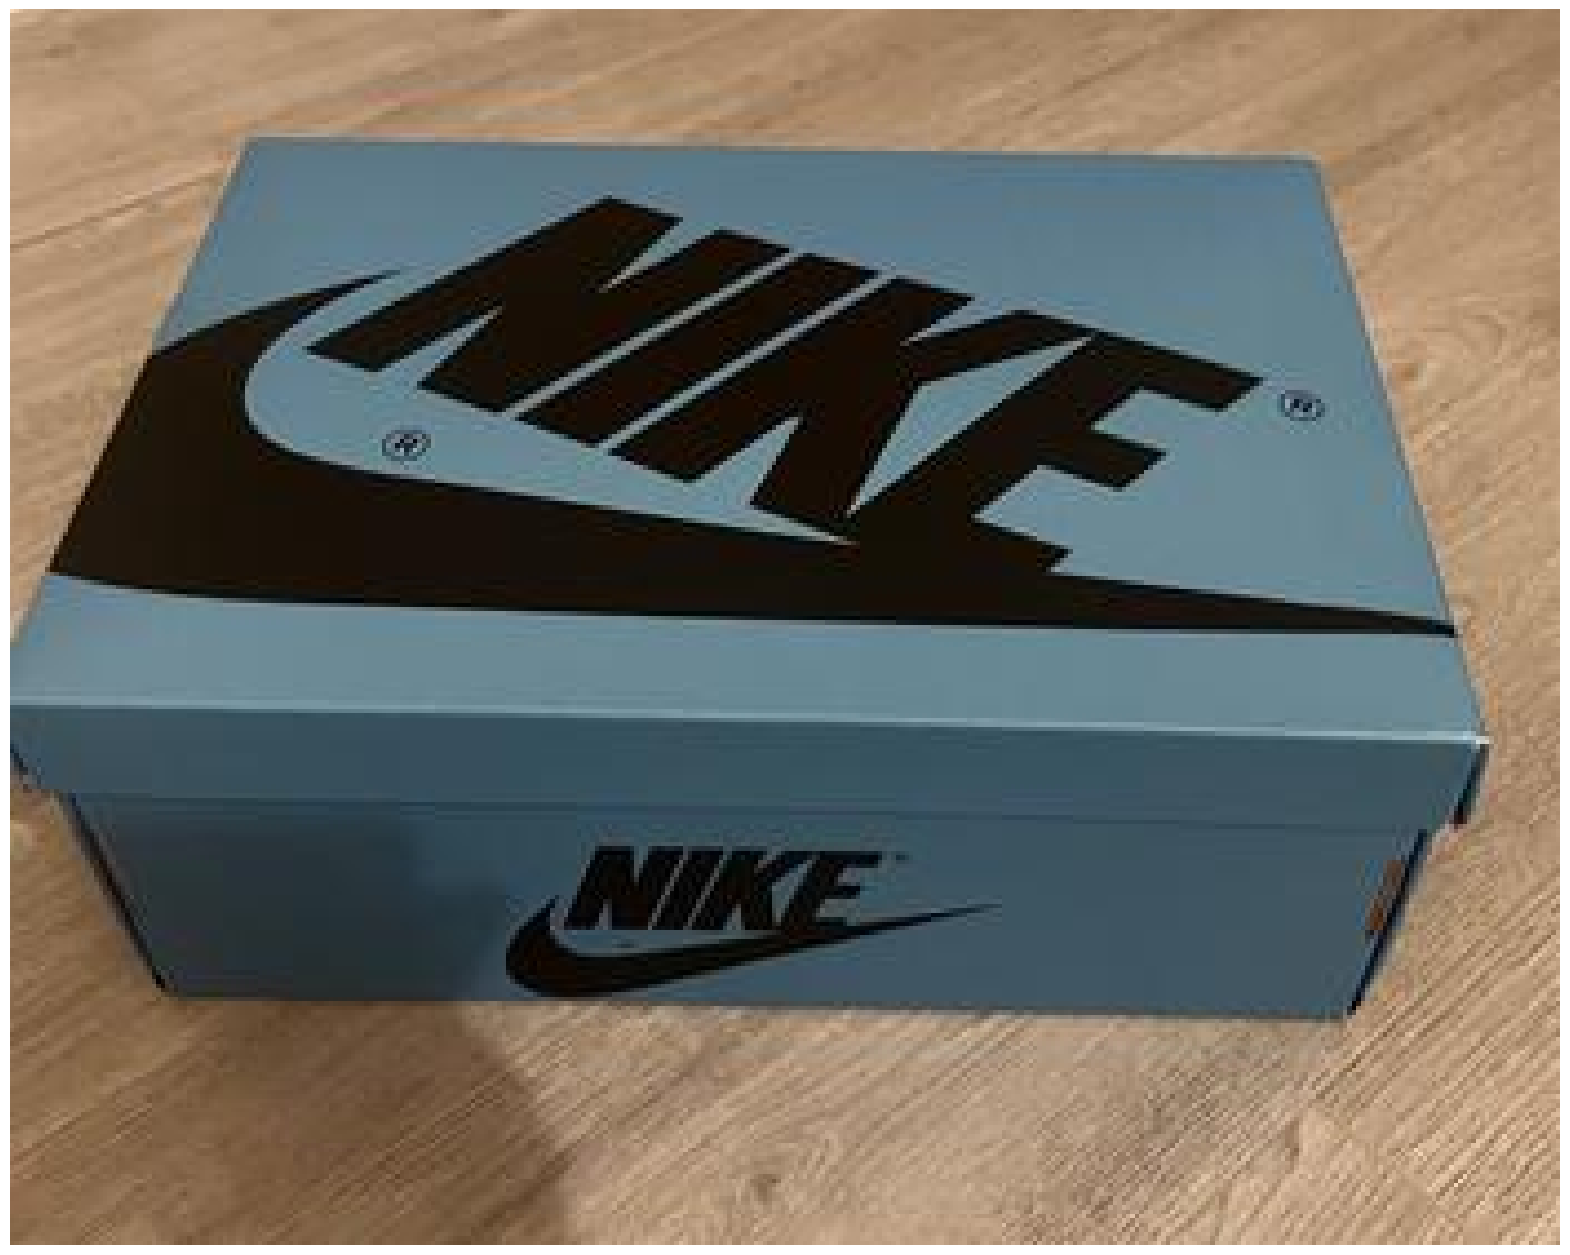

In [21]:
img_name = 'images/multiplechoice-images/375178531871.jpg'
image = Image.open('/data/chatgpt/notebooks/mnulli/aspect_pred_benchmarks/data/images/multiplechoice-images/375178531871.jpg')
image = np.array(image.convert("RGB"))

plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

3


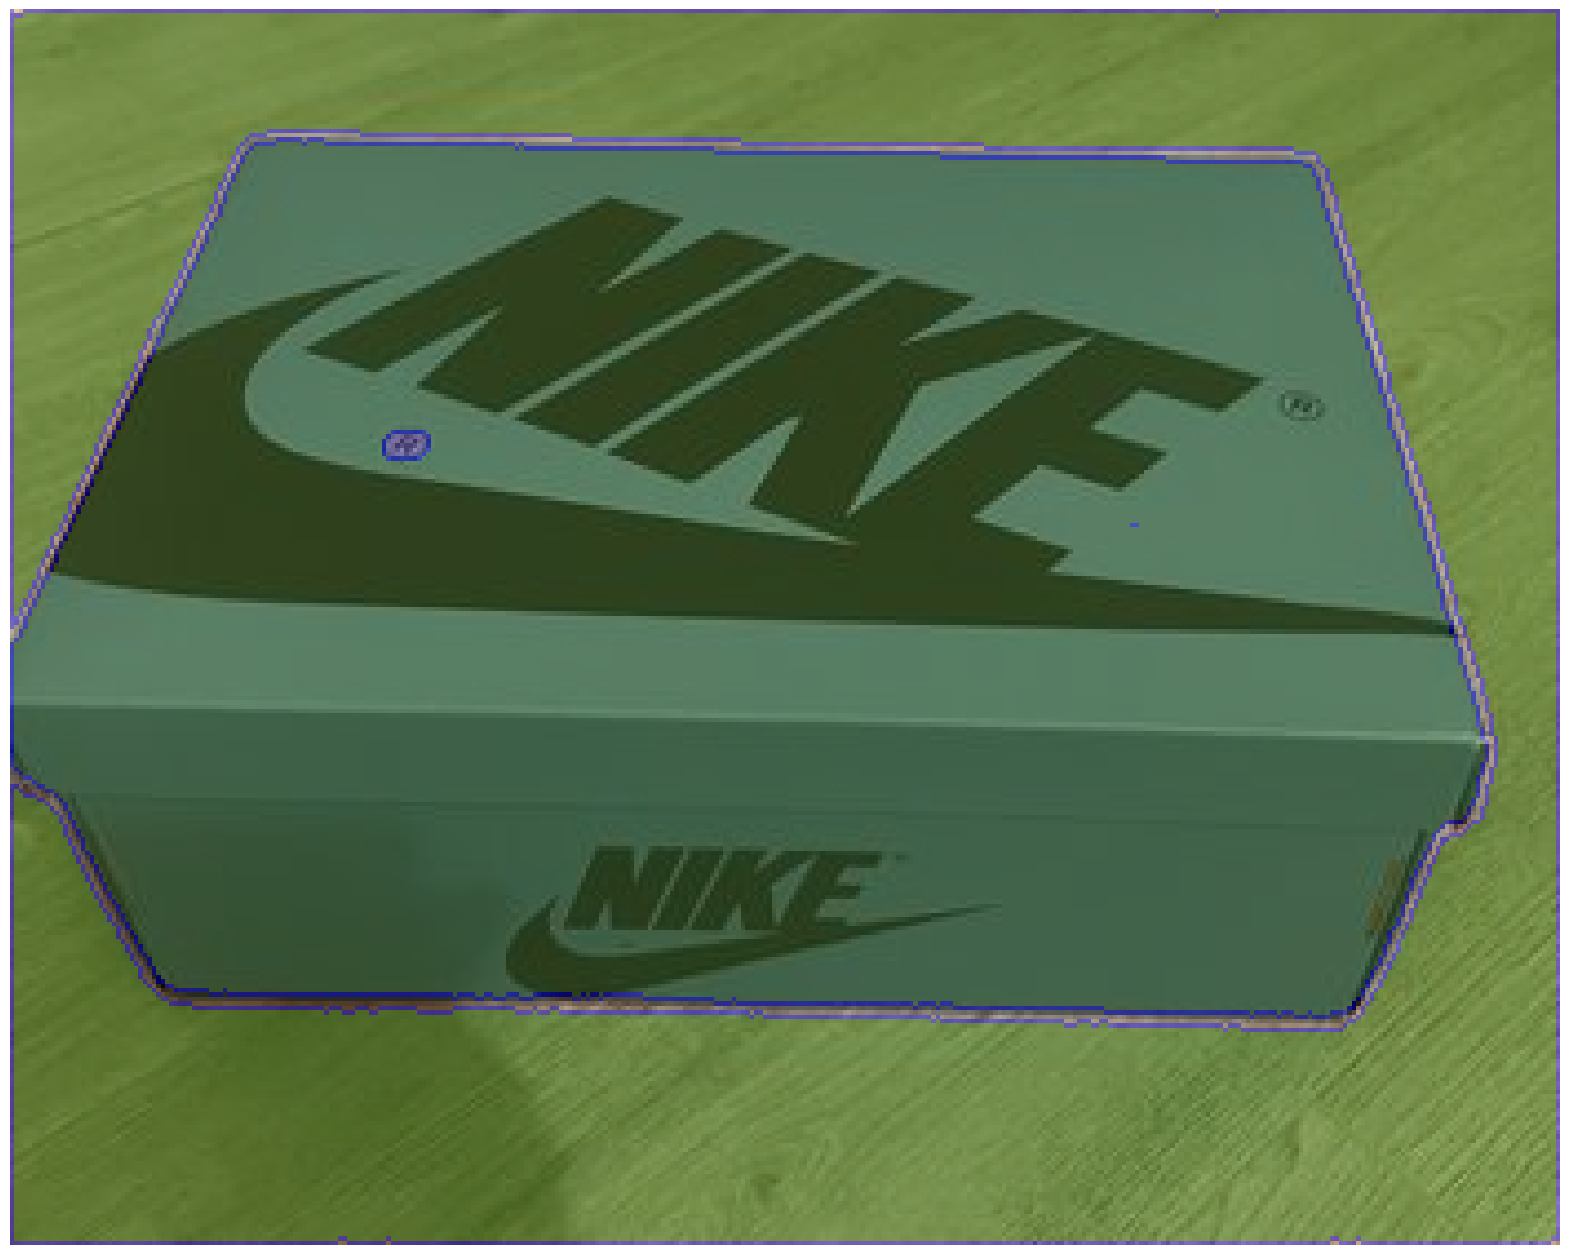

In [22]:
masks = mask_generator.generate(image)
print(len(masks))
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [18]:
import numpy as np
import json
import os
from typing import Dict, Any, List, Union
from tqdm import tqdm
from PIL import Image
import shutil
import tempfile


class SegmentationDataManager:
    def __init__(self, base_directory: str):
        """
        Initialize the manager with a base directory for storing all data.
        
        Args:
            base_directory (str): Directory where all data will be stored
        """
        self.base_directory = base_directory
        self.arrays_dir = os.path.join(base_directory, "arrays")
        self.metadata_file = os.path.join(base_directory, "metadata.json")
        self.backup_file = os.path.join(base_directory, "metadata_backup.json")
        
        # Create directories if they don't exist
        os.makedirs(self.arrays_dir, exist_ok=True)
        
        # Initialize or recover metadata file
        self._initialize_or_recover_metadata()

    def _safe_json_read(self, filepath: str) -> Dict:
        """
        Safely read JSON file with error handling and recovery.
        """
        try:
            with open(filepath, 'r') as f:
                return json.load(f)
        except json.JSONDecodeError:
            # Try to recover the JSON by reading until the last valid line
            with open(filepath, 'r') as f:
                content = f.read()
            
            # Find the last complete object (ending with })
            last_brace_index = content.rfind('}')
            if last_brace_index != -1:
                valid_content = content[:last_brace_index + 1]
                try:
                    return json.loads(valid_content)
                except json.JSONDecodeError:
                    pass
            
            # If recovery failed, return empty dict
            return {}

    def _safe_json_write(self, data: Dict, filepath: str) -> None:
        """
        Safely write JSON file using a temporary file.
        """
        # Create a temporary file in the same directory
        temp_dir = os.path.dirname(filepath)
        with tempfile.NamedTemporaryFile(mode='w', dir=temp_dir, delete=False) as tf:
            # Write to temporary file
            json.dump(data, tf, indent=2)
            temp_filepath = tf.name
        
        # Rename temporary file to target file (atomic operation)
        shutil.move(temp_filepath, filepath)

    def _initialize_or_recover_metadata(self) -> None:
        """
        Initialize metadata file or recover from backup if main file is corrupted.
        """
        metadata = {}
        
        # Try to read main metadata file
        if os.path.exists(self.metadata_file):
            metadata = self._safe_json_read(self.metadata_file)
        
        # If main file is empty or corrupted, try backup
        if not metadata and os.path.exists(self.backup_file):
            metadata = self._safe_json_read(self.backup_file)
        
        # Save recovered or empty metadata
        self._safe_json_write(metadata, self.metadata_file)
        # Create backup
        self._safe_json_write(metadata, self.backup_file)

    def list_image_keys(self):
        """
        Check if an image has already been processed and saved.
        """
        metadata = self._safe_json_read(self.metadata_file)
        image_keys_list = []  
        for image_key, val in metadata.items():
            image_keys_list.append(image_key)

        return image_keys_list
    
    
    def save_data(self, image_key: str, segmentations: List[Dict[str, Any]]) -> None:
        """
        Save multiple segmentation data for a single image.
        """
        # Create image directory
        image_arrays_dir = os.path.join(self.arrays_dir, image_key)
        os.makedirs(image_arrays_dir, exist_ok=True)
        
        # Load existing metadata
        metadata = self._safe_json_read(self.metadata_file)
        
        # Initialize or get existing image metadata
        metadata[image_key] = []
        
        # Save each segmentation
        for idx, seg_dict in enumerate(segmentations):
            # Save the numpy array
            array_filename = f"segmentation_{idx}.npy"
            array_path = os.path.join(image_arrays_dir, array_filename)
            np.save(array_path, seg_dict['segmentation'])
            
            # Prepare metadata
            meta_entry = seg_dict.copy()
            meta_entry['segmentation'] = array_filename
            
            # Add metadata for this segmentation
            metadata[image_key].append(meta_entry)
        
        # Save updated metadata and backup
        self._safe_json_write(metadata, self.metadata_file)
        self._safe_json_write(metadata, self.backup_file)
        
    def process_dataset(self, data: List[Dict[str, str]], mask_generator: Any) -> None:
        """
        Process a dataset of images, generating and saving masks only for unprocessed images.
        """
        image_keys = self.list_image_keys()

        for i in tqdm(range(len(data))):
            # Get image key
            image_key = data[i]['image'].strip('/mnt/nushare2/data/baliao/multimodal/data/')
            
            # Check if image has already been processed
            if image_key in image_keys:
                continue
            
            try:
                # Get image path
                image_path = data[i]['image']
                    
                # Process image and generate masks
                image = Image.open(image_path)
                image = np.array(image.convert("RGB"))
                masks = mask_generator.generate(image)
                
                # Save masks
                self.save_data(image_key, masks)
                
            except Exception as e:
                print(f"Error processing image {image_key}: {str(e)}")
                continue

    
    def load_data(self, image_key: str, indices: Union[int, List[int]] = None) -> Union[Dict[str, Any], List[Dict[str, Any]]]:
        """
        Load segmentation data for a specific image.
        """
        metadata = self._safe_json_read(self.metadata_file)
            
        if image_key not in metadata:
            raise KeyError(f"No data found for image: {image_key}")
        
        image_metadata = metadata[image_key]
        image_arrays_dir = os.path.join(self.arrays_dir, image_key)
        
        # Handle single index
        if isinstance(indices, int):
            metadata = image_metadata[indices].copy()
            array_path = os.path.join(image_arrays_dir, metadata['segmentation'])
            metadata['segmentation'] = np.load(array_path)
            return metadata
        
        # Handle multiple indices or None (all segmentations)
        load_indices = indices if indices is not None else range(len(image_metadata))
        result = []
        
        for idx in load_indices:
            metadata = image_metadata[idx].copy()
            array_path = os.path.join(image_arrays_dir, metadata['segmentation'])
            metadata['segmentation'] = np.load(array_path)
            result.append(metadata)
        
        return result

In [19]:

manager = SegmentationDataManager("segmentation_data")

manager.process_dataset(data, mask_generator)

  2%|▏         | 11092/558128 [02:01<12:58:31, 11.71it/s]

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [11]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [12]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [13]:
print(len(masks))
print(masks[0].keys())

54
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

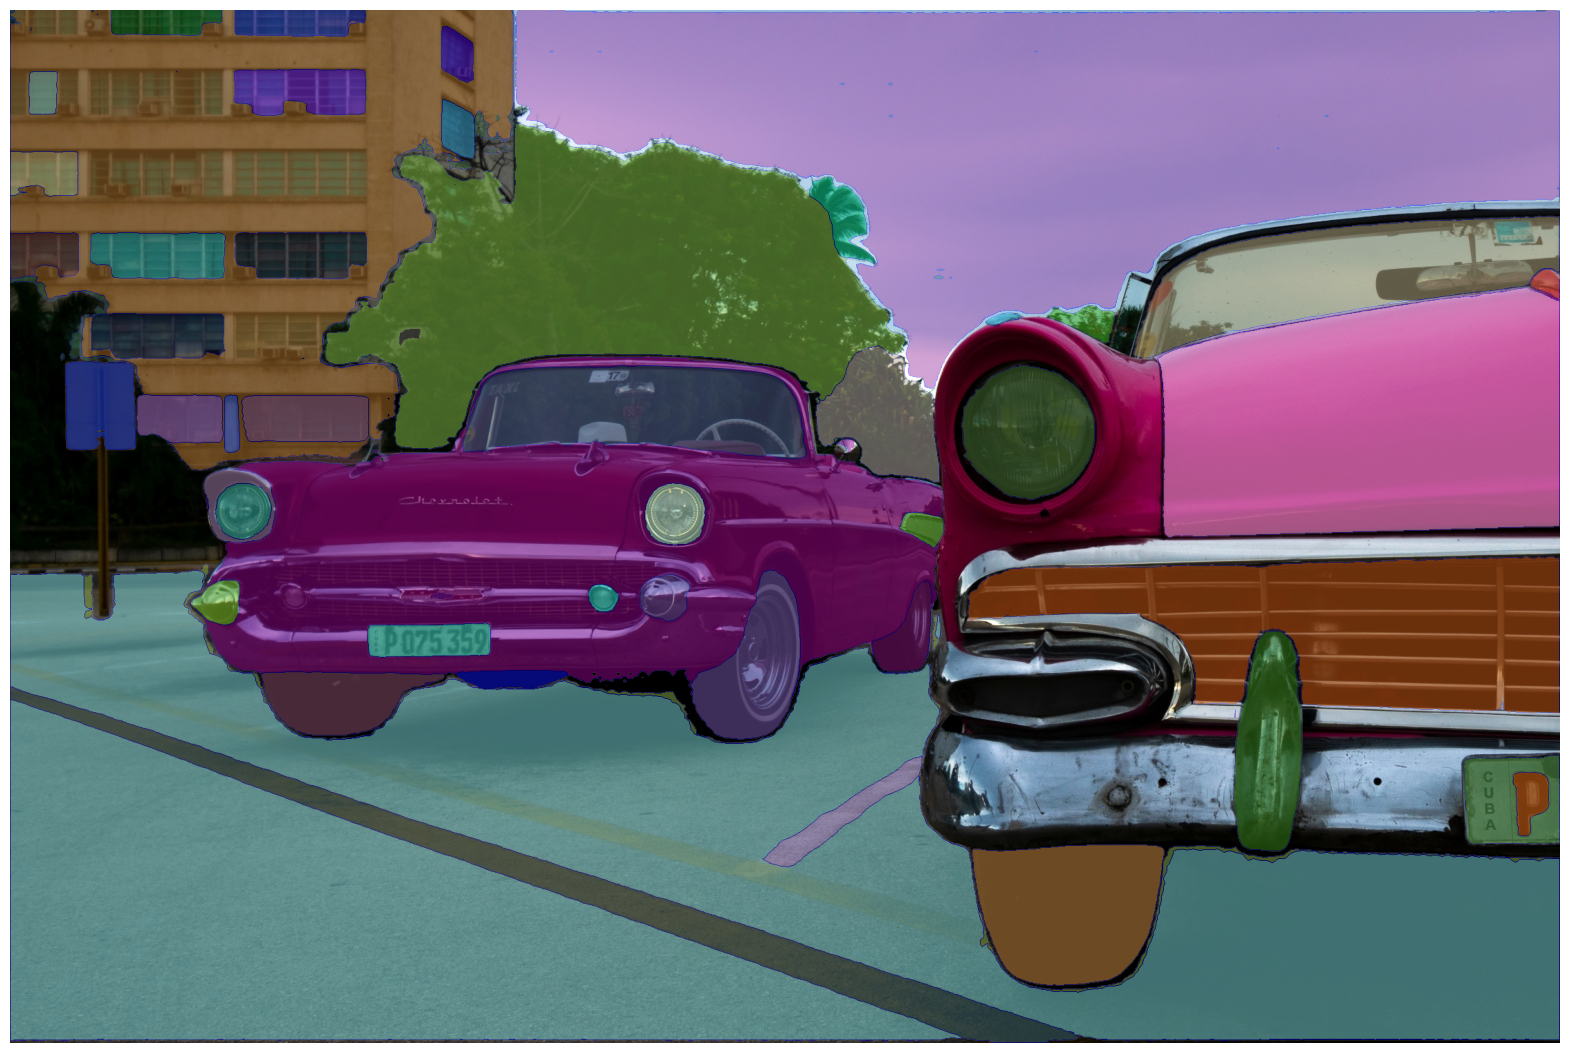

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [13]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [14]:
masks2 = mask_generator_2.generate(image)

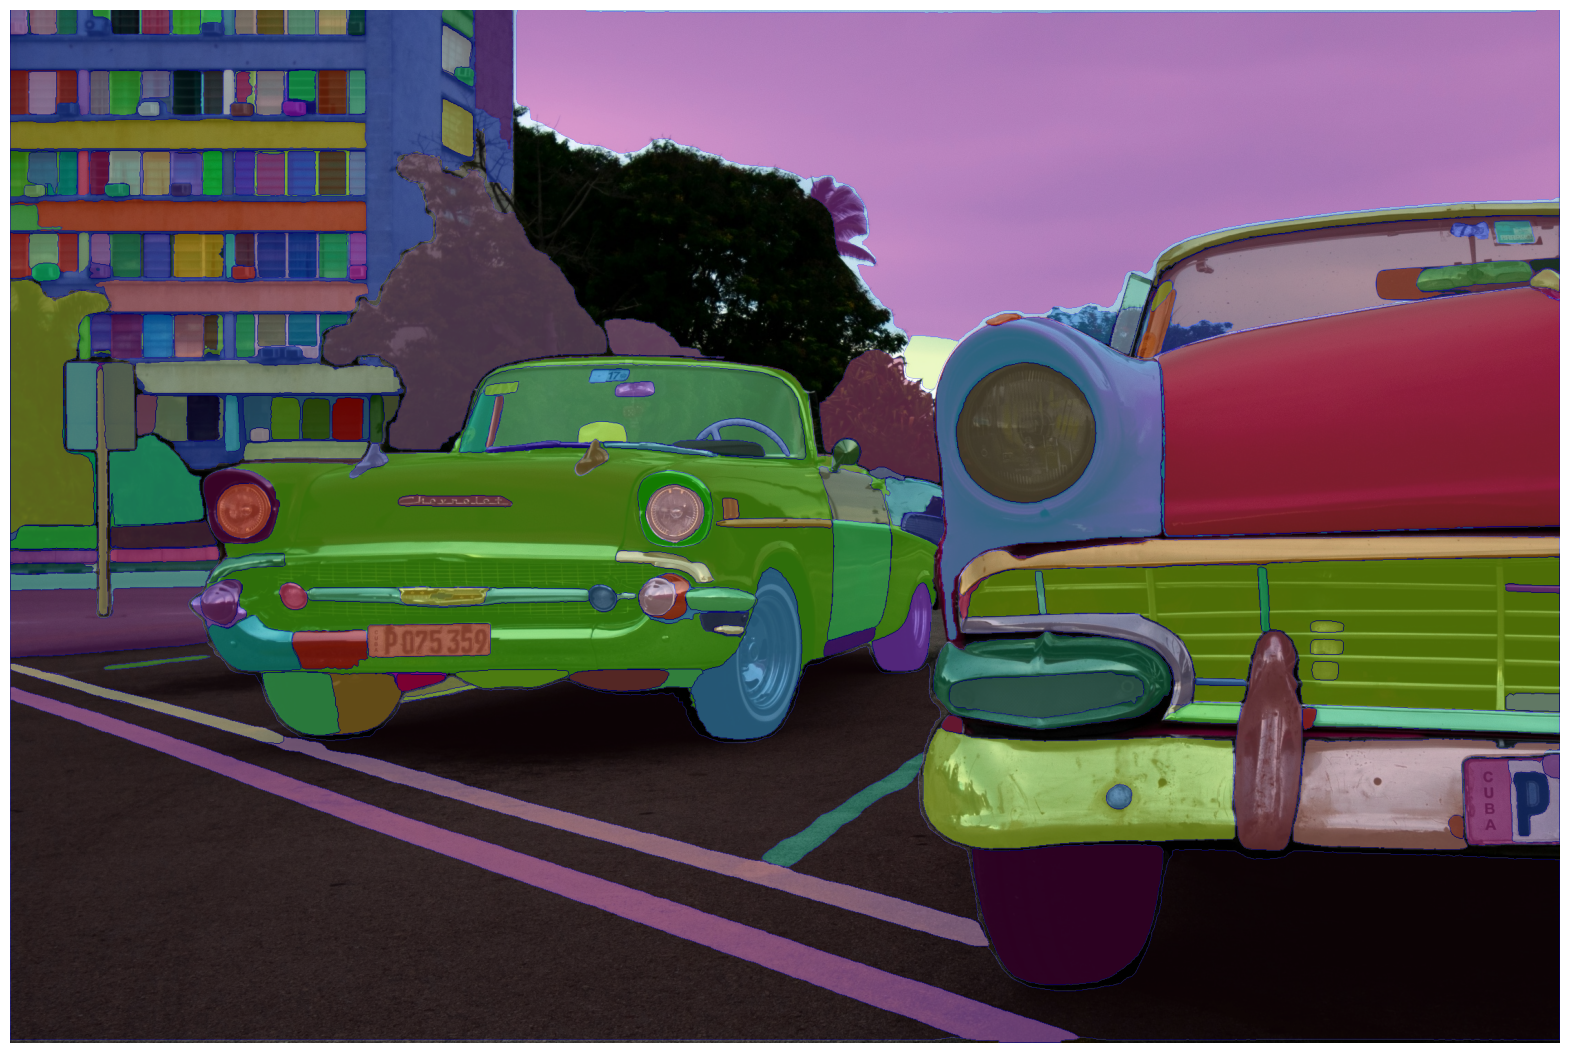

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 